# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [2]:
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1", na_values = -999).rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

In [3]:
pd.set_option('display.max_columns', None)
dat.head()

,AdultBodyMass,CranialCapacity,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,ActivityCycle,ForagingStratum,GestationLength,LitterSize,InterbirthInterval,HomeRange,PopulationDensity,SocialGrpSize,Longevity,Dry,Humid,Montane,Subarid,Subhumid
0,78.0,NaN,yes,no,yes,yes,no,yes,no,1.0,2.0,3.0,60.83,1.00,365.0,10.40,18.00,1.0,107.8,0,1,1,0,1
1,1082.0,NaN,no,no,yes,no,no,yes,no,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,1
2,946.0,NaN,no,no,yes,no,no,yes,no,2.0,1.0,3.0,NaN,NaN,NaN,0.02,NaN,NaN,NaN,1,0,0,0,0
3,1180.0,10.0,no,no,yes,no,no,yes,no,2.0,1.0,3.0,110.05,1.01,365.0,0.01,84.85,2.0,NaN,1,1,1,0,1
4,1212.5,NaN,no,no,yes,no,no,yes,no,1.0,1.0,3.0,NaN,NaN,NaN,NaN,114.00,NaN,NaN,0,1,0,1,1


In [4]:
# Filter for specified list of variables
dat = dat[["AdultBodyMass", "CranialCapacity", "Diet_Invertebrates", 
           "Diet_Vertebrates", "Diet_Fruits", "Diet_Flowers", 
           "Diet_Seeds", "Diet_Plants", "Diet_Other", 
           "HabitatBreadth", "ActivityCycle", "ForagingStratum", 
           "GestationLength", "LitterSize", "InterbirthInterval", 
           "HomeRange", "PopulationDensity", "SocialGrpSize", 
           "Longevity", "Dry", "Humid", 
           "Montane", "Subarid", "Subhumid"]]

In [5]:
# Create an empty list to store columns to keep
greater = []

# Loop through each column to check the percentage of missing values
for i in dat.columns:
    missing_perc = dat[i].isna().mean()
    if missing_perc <= 0.4:  
        greater.append(i)

# Make df of only percentages grater than 40%
birds = dat[greater]

In [6]:
print(f"Final DataFrame shape: {birds.shape}")

Final DataFrame shape: (214, 17)


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining columns using k-nearest neighbors with `KNNImputer()` for the numeric columns and using the mode for the categorical cariables. Use the 5 nearest neighbors for KNN. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations. Perform and print a check to ensure that there are no more NA values.

In [7]:
# Identify numeric and categorical columns
numeric_cols = birds.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = birds.select_dtypes(include=['object', 'category']).columns

In [8]:
birds.isna().sum()

AdultBodyMass          3
Diet_Invertebrates    15
Diet_Vertebrates      15
Diet_Fruits           15
Diet_Flowers          15
Diet_Seeds            15
Diet_Plants           15
Diet_Other            15
HabitatBreadth        26
ActivityCycle         22
ForagingStratum       24
LitterSize            83
Dry                    0
Humid                  0
Montane                0
Subarid                0
Subhumid               0
dtype: int64

In [9]:
# Impute numeric columns with KNN
imputer = KNNImputer(n_neighbors=5)

birds.loc[:, numeric_cols] = imputer.fit_transform(birds[numeric_cols])

In [10]:
# Impute categorical columns with mode
for col in categorical_cols:
    mode_value = birds[col].mode()[0]
    birds.loc[:, col] = birds[col].fillna(mode_value)

In [11]:
# Check for any remaining NA values
print("Missing values after imputation:")
print(birds.isna().sum())

Missing values after imputation:
AdultBodyMass         0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
dtype: int64


### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [12]:
# Create new column nClimates
climate_cols = ['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']
birds.loc[:,'nClimates'] = birds[climate_cols].sum(axis=1)

/tmp/ipykernel_214497/2443246235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  birds.loc[:,'nClimates'] = birds[climate_cols].sum(axis=1)


In [13]:
# Drop original climate columns
birds = birds.drop(columns=climate_cols)

In [14]:
# Encode categorical variables
encoder = LabelEncoder()

for col in categorical_cols:
    if col in birds.columns: 
        birds[col] = encoder.fit_transform(birds[col])

In [15]:
# Split the dataset
X = birds.drop(columns=['nClimates'])
y = birds['nClimates']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=808)

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

In [16]:
# Train a decision tree with max_depth=5
dt = DecisionTreeRegressor(max_depth=5, random_state=808)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=808)

In [17]:
# Make predictions
y_pred = dt.predict(X_test)

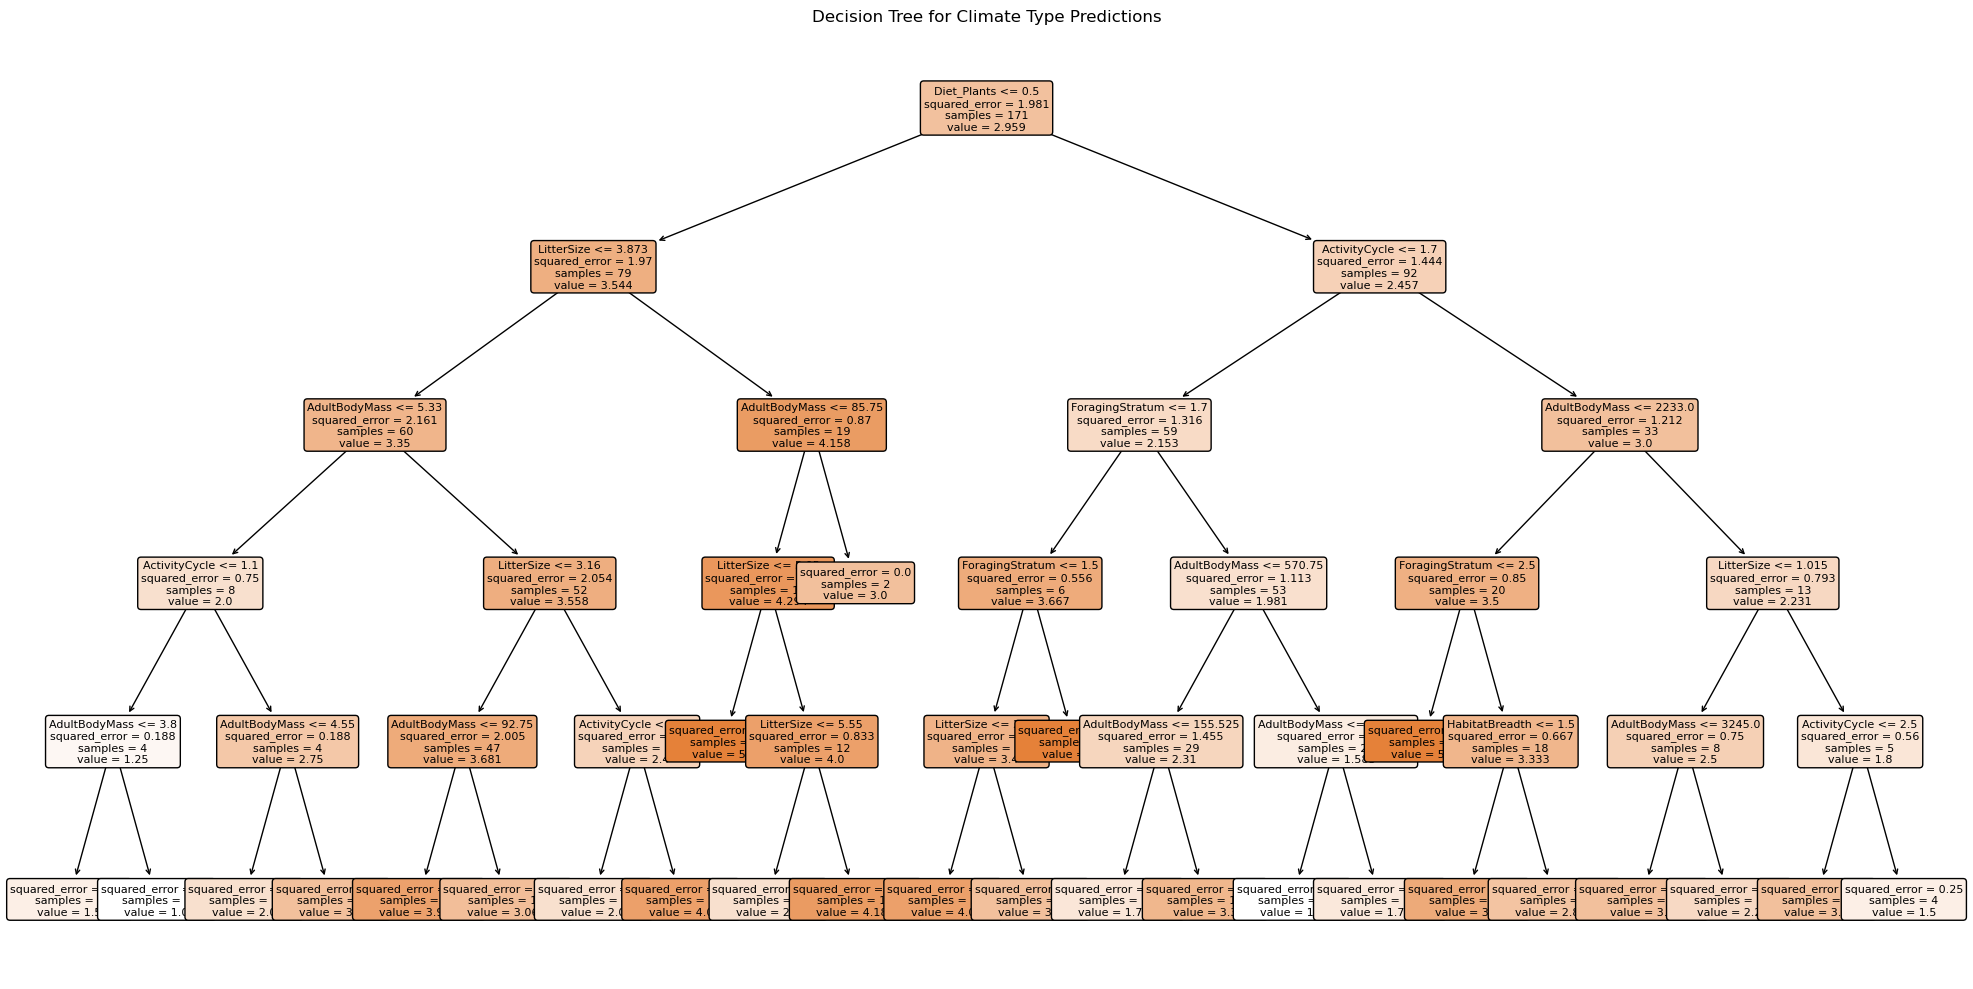

In [18]:
# Visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True, fontsize=8)
plt.title('Decision Tree for Climate Type Predictions')
plt.tight_layout()

plt.show()

In [19]:
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Decision Tree MSE: {mse:.4f}")

Decision Tree MSE: 2.3779


Based on the way this tree looks, what would you guess the most important variable to be?

Based on how this tree looks, I think the most important variable is adult body mass.

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [20]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 6, None]
}

In [21]:
# Initialize Random Forest model
rf = RandomForestRegressor(random_state=808)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

In [22]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=808), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 6, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [23]:
# Get best model
best_rf = grid_search.best_estimator_

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [24]:
# Make predictions with best model
rf_pred = best_rf.predict(X_test)

In [25]:
# Print best parameters
print("Best Parameters:")
print(grid_search.best_params_)

Best Parameters:
{'max_depth': 7, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


In [26]:
# Calculate and print MSE
rf_mse = mean_squared_error(y_test, rf_pred)
print(f"Random Forest MSE: {rf_mse:.4f}")

Random Forest MSE: 1.6779


In [27]:
# Feature importance
importances = best_rf.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

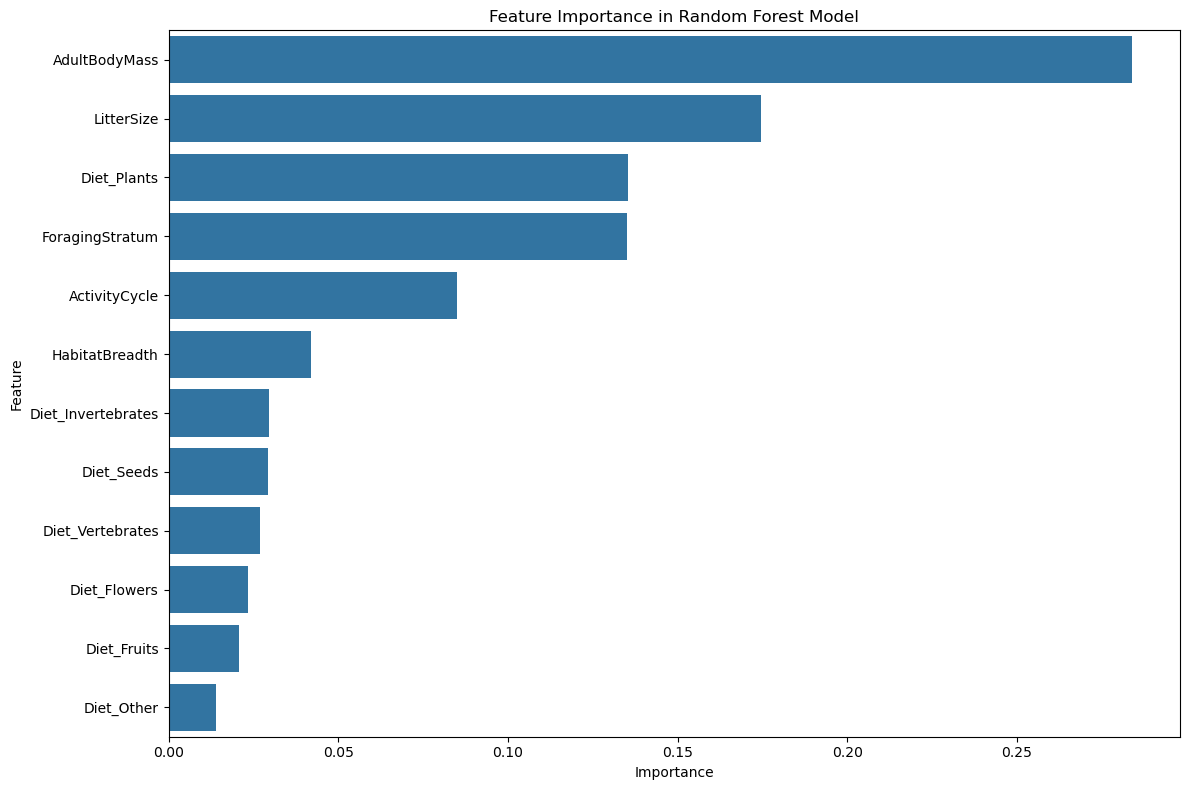

In [28]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()

plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

The model that had better accuracy is the random forest model. (Since it has a lower MSE, this indicates that it is making more accurate predictions.) The top traits that have the most influence on species' climate adaptability are: adult body mass, litter size, and whether the species eats plants, foraging stratum, and activity cycle.